In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import MetaTrader5 as mt5
import time
import struct
# import trinket

In [2]:
# подключимся к MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    quit()

In [33]:
#Получим тики EURRUB и USDRUB со вчерашнего дня по сегодняшний день
def take_ticks():
    eurrub_ticks = mt5.copy_ticks_range("GBPUSD",
                                         datetime.now() - timedelta(minutes=1),
                                         datetime.now(),
                                         mt5.COPY_TICKS_ALL)

    usdrub_ticks = mt5.copy_ticks_range("EURUSD", 
                                         datetime.now() - timedelta(minutes=1),
                                         datetime.now(),
                                         mt5.COPY_TICKS_ALL)
    return eurrub_ticks, usdrub_ticks

In [34]:
# подготовка запроса
symbol_Euro = "EURUSD"
symbol_gbp = "GBPUSD"
symbol_Euro_info =mt5.symbol_info(symbol_Euro)
symbol_gbp_info =mt5.symbol_info(symbol_gbp)
lot = 0.01# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
point_dol = mt5.symbol_info(symbol_Euro).point 
price_dol = mt5.symbol_info_tick(symbol_Euro).ask
price_euro = mt5.symbol_info_tick(symbol_gbp).ask
point_euro = mt5.symbol_info(symbol_gbp).point
deviation = 1 # deviation = отклонение
# запросы

#  struct MqlTradeRequest
#   {
#    ENUM_TRADE_REQUEST_ACTIONS    action;           // Тип выполняемого действия
#    ulong                         magic;            // Штамп эксперта (идентификатор magic number)
#    ulong                         order;            // Тикет ордера
#    string                        symbol;           // Имя торгового инструмента
#    double                        volume;           // Запрашиваемый объем сделки в лотах
#    double                        price;            // Цена 
#    double                        stoplimit;        // Уровень StopLimit ордера
#    double                        sl;               // Уровень Stop Loss ордера
#    double                        tp;               // Уровень Take Profit ордера
#    ulong                         deviation;        // Максимально приемлемое отклонение от запрашиваемой цены
#    ENUM_ORDER_TYPE               type;             // Тип ордера
#    ENUM_ORDER_TYPE_FILLING       type_filling;     // Тип ордера по исполнению
#    ENUM_ORDER_TYPE_TIME          type_time;        // Тип ордера по времени действия
#    datetime                      expiration;       // Срок истечения ордера (для ордеров типа ORDER_TIME_SPECIFIED)
#    string                        comment;          // Комментарий к ордеру
#    ulong                         position;         // Тикет позиции
#    ulong                         position_by;      // Тикет встречной позиции
#   };
   

# request-ПОКУПКА ДОЛЛАРА
# request_2-ПРОДАЖА ДОЛЛАРА
# request2-ПРОДАЖА ЕВРО
# request2_2-ПОКУПКА ЕВРО
# request3-ПОКУПКА ВСЕГО ЕВРО
# request3_2-ПРОДАЖА ВСЕГО ДОЛЛАРА




request = { 
"action": mt5.TRADE_ACTION_DEAL, 
"symbol": symbol_Euro, 
"volume": lot, 
"type": mt5.ORDER_TYPE_BUY, 
"price": price_dol, 
"stoplimit": price_dol*1.25,
"deviation": deviation, 
"magic": 123456, 
"comment": "купили доллар", 
"type_time": mt5.ORDER_TIME_GTC, 
"type_filling": mt5.ORDER_FILLING_FOK, 
}

request2 = {
"action": mt5.TRADE_ACTION_DEAL,
"symbol": symbol_gbp, # Сделка EURRUB
"volume": lot, # Объем который мы покупаем
"type": mt5.ORDER_TYPE_SELL,
"price": price_euro,
"deviation": deviation,
"magic": 123456, #Идентификатор эксперта. Позволяет организовать аналитическую обработку торговых ордеров.
"comment": "продажа евро",
"type_time": mt5.ORDER_TIME_GTC,        # Ордер будет находиться в очереди до тех пор, пока не будет снят
"type_filling": mt5.ORDER_FILLING_FOK,   
}

order_euro_buy = mt5.order_send(request)
order_gbp_sell = mt5.order_send(request2)

request_2 = {
"action": mt5.TRADE_ACTION_DEAL,# Совершить сделку прямо сейчас
"symbol": symbol_Euro, # Сделка USDRUB
"volume": lot, # Объем который мы покупаем
"type": mt5.ORDER_TYPE_SELL, # Покупаем или продаём
"position": order_euro_buy.order,  
#"price": price, # Для .TRADE_ACTION_DEAL не требуется
"deviation": deviation, # Максимальное отклонение от заданной цены
"magic": 123456, #Идентификатор эксперта. Позволяет организовать аналитическую обработку торговых ордеров.
"comment": "продали доллар",
"type_time": mt5.ORDER_TIME_GTC,
"type_filling": mt5.ORDER_FILLING_FOK,   #не будет продажи если нет необходимого обьема 
    
                                            #Означает согласие совершить сделку 
                                            #по максимально доступному на рынке 
                                            #объему в пределах указанного в ордере. 
                                            #В случае невозможности полного исполнения ордер 
                                            #будет исполнен на доступный объем, а неисполненный объем ордера будет отменен.
}

request2_2= {
"action": mt5.TRADE_ACTION_DEAL,
"symbol": symbol_gbp, # Сделка EURRUB
"volume": lot,
"type": mt5.ORDER_TYPE_BUY,
"position": order_gbp_sell.order, 
"deviation": deviation,
"magic": 123456, #Идентификатор эксперта. Позволяет организовать аналитическую обработку торговых ордеров.
"comment": "купили евро",
"type_time": mt5.ORDER_TIME_GTC,        # Ордер будет находиться в очереди до тех пор, пока не будет снят
"type_filling": mt5.ORDER_FILLING_FOK,      
}


request_3 = {
"action": mt5.TRADE_ACTION_DEAL,# Совершить сделку прямо сейчас
"symbol": symbol_Euro, # Сделка USDRUB
"volume": 5.0,
"type": mt5.ORDER_TYPE_SELL, # Покупаем или продаём
"position": order_euro_buy.order,
"deviation": deviation, # Максимальное отклонение от заданной цены
"magic": 123456, #Идентификатор эксперта. Позволяет организовать аналитическую обработку торговых ордеров.
"comment": "продали доллар",
"type_time": mt5.ORDER_TIME_GTC,
"type_filling": mt5.ORDER_FILLING_IOC,
    
                                            #Означает согласие совершить сделку 
                                            #по максимально доступному на рынке 
                                            #объему в пределах указанного в ордере. 
                                            #В случае невозможности полного исполнения ордер 
                                            #будет исполнен на доступный объем, а неисполненный объем ордера будет отменен.
}
request3_3= {
"action": mt5.TRADE_ACTION_DEAL,
"symbol": symbol_gbp, # Сделка EURRUB
"volume": 5.0,
"type": mt5.ORDER_TYPE_BUY,
"position": order_gbp_sell.order,
"deviation": deviation,
"magic": 123456, #Идентификатор эксперта. Позволяет организовать аналитическую обработку торговых ордеров.
"comment": "купили евро",
"type_time": mt5.ORDER_TIME_GTC,        # Ордер будет находиться в очереди до тех пор, пока не будет снят
"type_filling": mt5.ORDER_FILLING_IOC,      #Означает согласие совершить сделку 
                                            #по максимально доступному на рынке 
                                            #объему в пределах указанного в ордере. 
                                            #В случае невозможности полного исполнения ордер 
                                            #будет исполнен на доступный объем, а неисполненный объем ордера будет отменен.
}

In [35]:
def ticks_to_df(eurrub_ticks,usdrub_ticks):
    #Переведем имеющиеся у нас данные в DataFrame
    eurrub_ticks_frame = pd.DataFrame(eurrub_ticks)
    usdrub_ticks_frame = pd.DataFrame(usdrub_ticks)
    #Время в MetaTrader 5 хранится в UTC таймзоне, поэтому переведем в привычный нам вид
    eurrub_ticks_frame['time']=pd.to_datetime(eurrub_ticks_frame['time'], unit='s')
    usdrub_ticks_frame['time']=pd.to_datetime(usdrub_ticks_frame['time'], unit='s')

    #Удалим ненужные столбцы
    eurrub_ticks_frame.drop('ask', axis = 1, inplace = True)
    eurrub_ticks_frame.drop('flags', axis = 1, inplace = True)
    eurrub_ticks_frame.drop('volume_real', axis = 1, inplace = True)
    eurrub_ticks_frame.drop('last', axis = 1, inplace = True)
    eurrub_ticks_frame.drop('volume', axis = 1, inplace = True)

    usdrub_ticks_frame.drop('bid', axis = 1, inplace = True)
    usdrub_ticks_frame.drop('flags', axis = 1, inplace = True)
    usdrub_ticks_frame.drop('volume_real', axis = 1, inplace = True)
    usdrub_ticks_frame.drop('last', axis = 1, inplace = True)
    usdrub_ticks_frame.drop('volume', axis = 1, inplace = True)
    return eurrub_ticks_frame, usdrub_ticks_frame

In [36]:
def change_ticks_df(eurrub_ticks_frame,usdrub_ticks_frame):
    position_euro = 0
    position_usd = 0
    old_euro = eurrub_ticks_frame['bid'][0]
    old_usd = usdrub_ticks_frame['ask'][0]
    current_usd = old_usd
    current_euro = old_euro

    spread = []

    while(position_euro <= len(eurrub_ticks_frame['time'])):

        if(eurrub_ticks_frame['time_msc'][position_euro] >= usdrub_ticks_frame['time_msc'][position_usd]):

            current_usd = usdrub_ticks_frame['ask'][position_usd]
            spread.append(current_euro - current_usd)
            old_usd = usdrub_ticks_frame['ask'][position_usd]
            if position_usd >= len(usdrub_ticks_frame['time']) - 1:
                break
            position_usd += 1
        else:

            current_euro = eurrub_ticks_frame['bid'][position_euro]
            spread.append(current_euro - old_usd)
            if position_euro >= len(eurrub_ticks_frame['time']) - 1:
                break
            position_euro += 1
            plt.plot(spread)
    return spread

In [37]:
def open_close(spread):
    #максимальное и минимальное значение
    max_spread = max(spread)
    min_spread = min(spread)
    #Найдём медиану
    spread = np.array(spread)
    median = np.median(spread)
    print('median:     ',median,
          '\nmax spread: ', max_spread,
          '\nmin_spread: ',min_spread)
    Open = median + (max_spread - median) * 0.7
    print('Open:', Open)
    Close = median + (min_spread - median) * 0.1
    print('Close', Close)
    return Open, Close

In [38]:
def request_open_pos(): 
    result =mt5.order_send(request) 
    result2 = mt5.order_send(request2)
    print('Открыл')
    #print(result)
    #print(result2)

In [39]:
def request_close_pos():
    result = mt5.order_send(request_2) 
    result2 = mt5.order_send(request2_2)
    print('Закрыл')
    #print(result)
    #print(result2)

In [40]:
def request_close_pos_all():
    result = mt5.order_send(request_3) 
    result2 = mt5.order_send(request3_3)
    #print('Закрыли все позиции')
    print(result)
    print(result2)

median:      0.17313 
max spread:  0.17317000000000005 
min_spread:  0.17308999999999997
Open: 0.17315800000000003
Close 0.173126


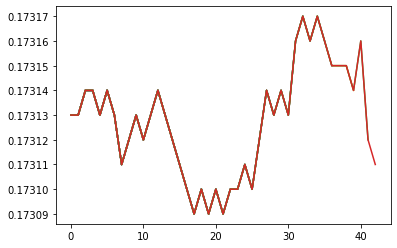

In [41]:
take_ticks()
a = ticks_to_df(take_ticks()[0],take_ticks()[1])
b = change_ticks_df(a[0], a[1])
Open,Close = open_close(b)

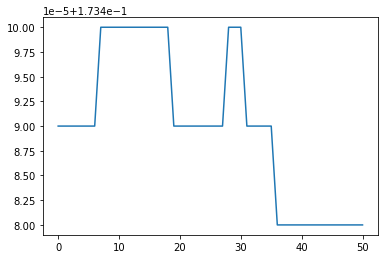

In [51]:
plt.plot(spread1)

In [56]:
median = np.median(spread1)
median

0.17328999999999994

In [44]:
spread1 = []

last_spread: 0.17328999999999994
Open: 0.17306899999999997
Close: 0.17128583999999994
Открыл
last_spread: 0.17328999999999994
Open: 0.17306899999999997
Close: 0.17128583999999994
Открыл
last_spread: 0.1732699999999998
Open: 0.17306899999999997
Close: 0.17128583999999994
Открыл
last_spread: 0.1732699999999998
Open: 0.17306899999999997
Close: 0.17128583999999994
Открыл
last_spread: 0.1732699999999998
Open: 0.17306899999999997
Close: 0.17128583999999994
Открыл
last_spread: 0.17327999999999988
Open: 0.17306899999999997
Close: 0.17128583999999994
Открыл
last_spread: 0.17327999999999988
Open: 0.17306899999999997
Close: 0.17128583999999994
Открыл
last_spread: 0.17327999999999988
Open: 0.17306899999999997
Close: 0.17128583999999994
Открыл
last_spread: 0.17327999999999988
Open: 0.17306899999999997
Close: 0.17128583999999994
Открыл
last_spread: 0.17327999999999988
Open: 0.17306899999999997
Close: 0.17128583999999994
Открыл
last_spread: 0.17328999999999994
Open: 0.17306899999999997
Close: 0.17128

Открыл
last_spread: 0.1732499999999999
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17322999999999977
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17323999999999984
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327000000000004
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327000000000004
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327999999999988
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327999999999988
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327999999999988
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327999999999988
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327999999999988
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327999999999988
Open: 0.17299799999999993
Close

Открыл
last_spread: 0.17327000000000004
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327000000000004
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327000000000004
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.1732800000000001
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.1732800000000001
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.1732800000000001
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17328999999999994
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17328999999999994
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17328999999999994
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17328999999999994
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17328999999999994
Open: 0.17299799999999993
Close: 

Открыл
last_spread: 0.1733
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.1733
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.1733
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.1733
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17328999999999994
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17328999999999994
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17330999999999985
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17330999999999985
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.1733
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.1733
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.1733
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.1733
Open: 0.17299799999999993
Close: 0.171234

Открыл
last_spread: 0.17327000000000004
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327000000000004
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327000000000004
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327000000000004
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327000000000004
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327000000000004
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17327000000000004
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17325999999999997
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17325999999999997
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17325999999999997
Open: 0.17299799999999993
Close: 0.17123436000000006
Открыл
last_spread: 0.17325999999999997
Open: 0.17299799999999993
Clos

KeyboardInterrupt: 

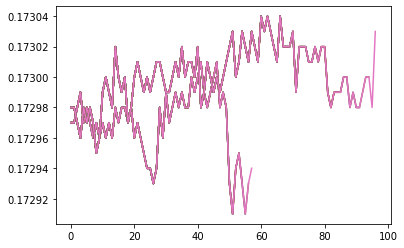

In [55]:
while(True):
    if datetime.now().second % 28 == 0 and datetime.now().second != 0:
        request_close_pos_all()
        time.sleep(1)
    if datetime.now().second == 2:
        take_ticks()
        a = ticks_to_df(take_ticks()[0],take_ticks()[1])
        b = change_ticks_df(a[0], a[1])
        Open,Close = open_close(b)
        time.sleep(1)
    last_tick_usdrub = mt5.symbol_info_tick("EURUSD").bid
    last_tick_GPBUSD = mt5.symbol_info_tick("GBPUSD").ask
    last_spread = last_tick_GPBUSD - last_tick_usdrub
    spread1.append(last_spread)
    print('last_spread:',last_spread)
    print('Open:',Open)
    print('Close:',Close * 0.99)
    if last_spread > Open:
        request_open_pos() # Написать Функции
    elif last_spread < Close * 0.99:
        request_close_pos() # Написать Функции

In [136]:
Open

0.17183500000000015

In [139]:
last_spread

0.17222000000000004

In [63]:
mt5.shutdown()

True

###  Далее черновой код не использующийся в основной программе

In [41]:
while(True):
    print(datetime.now())

2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.409712
2021-02-10 22:27:40.410713
2021-02-10 22:27:40.410713
2021-02-10 22:27:40.410713
2021-02-10 22:27:40.410713
2021-02-10 22:27:40.410713
2021-02-10 22:27:40.410713
2

2021-02-10 22:27:40.590724
2021-02-10 22:27:40.669322
2021-02-10 22:27:40.669322
2021-02-10 22:27:40.669322
2021-02-10 22:27:40.669322
2021-02-10 22:27:40.669322
2021-02-10 22:27:40.669322
2021-02-10 22:27:40.669322
2021-02-10 22:27:40.669322
2021-02-10 22:27:40.669322
2021-02-10 22:27:40.669322
2021-02-10 22:27:40.669322
2021-02-10 22:27:40.669322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2021-02-10 22:27:40.670322
2

2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.885336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2021-02-10 22:27:40.886336
2

2021-02-10 22:27:41.059350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.060350
2021-02-10 22:27:41.061350
2021-02-10 22:27:41.061350
2021-02-10 22:27:41.061350
2021-02-10 22:27:41.061350
2021-02-10 22:27:41.061350
2021-02-10 22:27:41.061350
2021-02-10 22:27:41.061350
2021-02-10 22:27:41.061350
2021-02-10 22:27:41.061350
2021-02-10 22:27:41.061350
2

2021-02-10 22:27:41.252364
2021-02-10 22:27:41.252364
2021-02-10 22:27:41.252364
2021-02-10 22:27:41.252364
2021-02-10 22:27:41.252364
2021-02-10 22:27:41.252364
2021-02-10 22:27:41.252364
2021-02-10 22:27:41.252364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2021-02-10 22:27:41.253364
2

2021-02-10 22:27:41.429378
2021-02-10 22:27:41.454379
2021-02-10 22:27:41.454379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2021-02-10 22:27:41.455379
2

2021-02-10 22:27:41.661394
2021-02-10 22:27:41.661394
2021-02-10 22:27:41.661394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.662394
2021-02-10 22:27:41.663394
2021-02-10 22:27:41.663394
2

2021-02-10 22:27:41.838408
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.867401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2021-02-10 22:27:41.868401
2

2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2021-02-10 22:27:42.045417
2

2021-02-10 22:27:42.231966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.232966
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2021-02-10 22:27:42.233967
2

2021-02-10 22:27:42.420980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.421980
2021-02-10 22:27:42.422981
2021-02-10 22:27:42.422981
2021-02-10 22:27:42.422981
2021-02-10 22:27:42.422981
2021-02-10 22:27:42.422981
2021-02-10 22:27:42.422981
2021-02-10 22:27:42.422981
2021-02-10 22:27:42.422981
2021-02-10 22:27:42.422981
2021-02-10 22:27:42.422981
2021-02-10 22:27:42.422981
2

2021-02-10 22:27:42.587993
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.609995
2021-02-10 22:27:42.610996
2021-02-10 22:27:42.610996
2021-02-10 22:27:42.610996
2021-02-10 22:27:42.610996
2021-02-10 22:27:42.610996
2021-02-10 22:27:42.610996
2021-02-10 22:27:42.610996
2021-02-10 22:27:42.610996
2

2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.810010
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2021-02-10 22:27:42.811011
2

2021-02-10 22:27:42.985022
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2021-02-10 22:27:43.008023
2

2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2021-02-10 22:27:43.202038
2

2021-02-10 22:27:43.378051
2021-02-10 22:27:43.403054
2021-02-10 22:27:43.403054
2021-02-10 22:27:43.403054
2021-02-10 22:27:43.403054
2021-02-10 22:27:43.403054
2021-02-10 22:27:43.403054
2021-02-10 22:27:43.403054
2021-02-10 22:27:43.403054
2021-02-10 22:27:43.403054
2021-02-10 22:27:43.403054
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.404053
2021-02-10 22:27:43.405054
2021-02-10 22:27:43.405054
2021-02-10 22:27:43.405054
2021-02-10 22:27:43.405054
2021-02-10 22:27:43.405054
2021-02-10 22:27:43.405054
2

2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.596069
2021-02-10 22:27:43.597068
2021-02-10 22:27:43.597068
2021-02-10 22:27:43.597068
2021-02-10 22:27:43.597068
2021-02-10 22:27:43.597068
2021-02-10 22:27:43.597068
2021-02-10 22:27:43.597068
2021-02-10 22:27:43.597068
2021-02-10 22:27:43.597068
2

2021-02-10 22:27:43.770080
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.791083
2021-02-10 22:27:43.792082
2021-02-10 22:27:43.792082
2021-02-10 22:27:43.793083
2021-02-10 22:27:43.793083
2021-02-10 22:27:43.793083
2021-02-10 22:27:43.793083
2021-02-10 22:27:43.793083
2021-02-10 22:27:43.793083
2021-02-10 22:27:43.793083
2021-02-10 22:27:43.793083
2

2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.985095
2021-02-10 22:27:43.986096
2

2021-02-10 22:27:44.156109
2021-02-10 22:27:44.177113
2021-02-10 22:27:44.177113
2021-02-10 22:27:44.177113
2021-02-10 22:27:44.177113
2021-02-10 22:27:44.177113
2021-02-10 22:27:44.177113
2021-02-10 22:27:44.177113
2021-02-10 22:27:44.178113
2021-02-10 22:27:44.178113
2021-02-10 22:27:44.178113
2021-02-10 22:27:44.178113
2021-02-10 22:27:44.178113
2021-02-10 22:27:44.178113
2021-02-10 22:27:44.178113
2021-02-10 22:27:44.178113
2021-02-10 22:27:44.178113
2021-02-10 22:27:44.178113
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2021-02-10 22:27:44.179111
2

2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.368124
2021-02-10 22:27:44.369124
2021-02-10 22:27:44.369124
2021-02-10 22:27:44.369124
2021-02-10 22:27:44.369124
2021-02-10 22:27:44.369124
2021-02-10 22:27:44.369124
2021-02-10 22:27:44.369124
2021-02-10 22:27:44.369124
2021-02-10 22:27:44.369124
2021-02-10 22:27:44.369124
2021-02-10 22:27:44.369124
2021-02-10 22:27:44.369124
2

KeyboardInterrupt: 

In [113]:
last_spread

0.17162999999999995

In [ ]:
from_date=datetime.now() - timedelta(days=1)
to_date=datetime.now()
history_orders=mt5.history_orders_total(from_date, datetime.now())
if history_orders>0:
    print("Total history orders=",history_orders)
else:
    print("Orders not found in history")

In [ ]:
positions_total=mt5.positions_total()
if positions_total>0:
    print("Total positions =",positions_total)
else:
    print("Positions not found")

In [24]:

lasttick=mt5.symbol_info_tick("GBPUSD")

lasttick.bid

1.36712

In [8]:
define EXPERT_MAGIC 123456   // MagicNumber эксперта
def OnStart():
   MqlTradeRequest request={0};
   MqlTradeResult  result={0};

   request.action   =TRADE_ACTION_DEAL;                     # тип торговой операции
   request.symbol   ="GBPUSD";                              # символ
   request.volume   =0.1;                                   # объем в 0.1 лот
   request.type     =ORDER_TYPE_BUY;                        # тип ордера
   request.price    =SymbolInfoDouble(Symbol(),SYMBOL_ASK); # цена для открытия
   request.deviation=5;                                     # допустимое отклонение от цены
   request.magic    =EXPERT_MAGIC;                         # MagicNumber ордера

   if(!OrderSend(request,result))
      PrintFormat("OrderSend error %d",GetLastError());     # если отправить запрос не удалось, вывести код ошибки
   PrintFormat("retcode=%u  deal=%I64u  order=%I64u",result.retcode,result.deal,result.order);

SyntaxError: invalid syntax (<ipython-input-8-7a7daa745a3e>, line 1)

In [ ]:
PrintFormat("retcode=%u  deal=%I64u  order=%I64u",result.retcode,result.deal,result.order);

In [ ]:
def user_login():
    try:
    login(
    login,                    // номер счета
    password="PASSWORD",      // пароль
    server="SERVER",          // имя сервера, как оно задано в терминале
    timeout=TIMEOUT           // таймаут
    )
    except  TimeoutErrore

# account=25115284
# authorized=mt5.login(account, password="gqrtz0lbdm")
# user_login()

def errors():
     print("initialize() failed, error code =",mt5.last_error())
#   

In [ ]:
Class Money:
    name = "RUB"
    price
# 
Class Dollar(Money):
    price
# 

Class Euro(Money):
    price
    def __init__(self,price):
        self.price = price
    def __del__():
        print(seld.price,"удален")
# 
euro = Euro()
